In [1]:
# Author: Leonie Küchenhoff
# Date: Sep 19th, 2022
# Script to check output and overlap of different variant callers

In [1]:
# package import
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import seaborn as sns
import itertools
from config import basedir, outdir, vartest, var_db_dir

In [2]:
# plot settings
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

In [3]:
# general settings
os.chdir(basedir)
outdir = f'{outdir}/varcaller_test'
samples = ['029_pbs_R', '033_nrch_R', '028_pbs_R', '030_nrch_R','032_pbs_R','036_nrch_R']
plat = [f'{vartest}//HL{i}.plat.txt' for i in samples]
strelka = [f'{vartest}/HL{i}.st.txt' for i in samples]
varscan = [f'{vartest}/HL{i}.varscan.txt' for i in samples]
rest = [f'merged/txt_files/HL{i}.merged.remdup.txt' for i in samples]
known_gen_vars_path = f'{var_db_dir}/normalized/genic_vars/genetic_variants.txt'

In [4]:
# read mgp variants that were first normalized and then filtered based on their vep annotation
known_gen_vars = pd.read_csv(known_gen_vars_path, sep = '\t', names = ['chr','pos','id','ref','alt','qual','filter','Info'], header = 0)[['chr','pos','ref','alt']].reset_index(drop = True)
known_gen_vars['known'] = True
tot_known_gen_vars = known_gen_vars.shape[0]

In [5]:
def get_sets(df_gt):
    '''
    function to get info where gt is  0/1 or 1/1 in the shape of a binary mask
    returns binary mask and indices of locations where variant is present
    '''
    # separate info from GT into two arrays (before: '0,1' - after: allel1 = [0], allel2 = [1])
    allel1 = df_gt.applymap(lambda x: x[0]).to_numpy()
    allel2 = df_gt.applymap(lambda x: x[2]).to_numpy()

    # replace '.' with -1 to ba able to use integers
    allel1[allel1 == '.'] = -1
    allel2[allel2 == '.'] = -1

    # transform arrays of strings to integer arrays
    allel1 = allel1.astype(int)
    allel2 = allel2.astype(int)

    # find all gt that are eiher 1/0 or 0/1 or 1/1 and create binary mask
    gt = allel1 + allel2
    binary = gt > 0

    # create ascending list of length of table that will be later used for venn diagrams
    setlist = np.arange(0,len(gt))
    return binary, setlist

def get_af(df, col1 = 'ad_h', col2 = 'ad_l'):
    '''
    function to get allele frequency of col1 and col2 within dataframe df
    returns numpy array with AF
    '''
    mouse_ad = df[[col1, col2]]
    allel1 = mouse_ad.applymap(lambda x: int(x.split(',')[0])).to_numpy()
    allel2 = mouse_ad.applymap(lambda x: int(x.split(',')[1])).to_numpy()
    af = allel2 / (allel1 + allel2)
    af = np.nan_to_num(af, 0)
    return af



In [6]:
var_dict = {}
for count, i in enumerate(samples): 
    '''
    for loop to read in data from different variant callers for all samples
    variant callers differ in their output format.
    Hence, tables need to be read slightly differently. 
    Dataframes are saved in var_dict with their sample name and variant caller as key.
    '''

    # strelka output requires exclusion of falsely formatted GT entires
    file = pd.read_csv(strelka[count], delimiter = '\t', names = ['chr','pos','ref','alt','AD|h_st','AD|l_st','GT|h_st','GT|l_st'], header = 0)
    file[file['chr'].isin([
    'chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
    'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
    'chrX', 'chrY'])]
    file = file[(file['GT|h_st']!= '1') & (file['GT|h_st']!= '0')]
    file = file[(file['GT|l_st']!= '1') & (file['GT|l_st']!= '0')]
    var_dict[str('strelka_'+i)] = file[['chr','pos','ref','alt','GT|h_st','GT|l_st','AD|h_st','AD|l_st']]
    

    # varscan output requires calculation of AD
    file = pd.read_csv(varscan[count], delimiter = '\t', names = ['chr','pos','ref','alt','VD_h','VD_l','RD_h','RD_l','GT|h_var','GT|l_var'], header = 0)
    file[file['chr'].isin([
    'chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
    'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
    'chrX', 'chrY'])]
    file = file.replace('.', 0)
    file['AD|h_var'] = list(map("{0[0]},{0[1]}".format, zip(file['RD_h'], file['VD_h'])))
    file['AD|l_var'] = list(map("{0[0]},{0[1]}".format, zip(file['RD_l'], file['VD_l'])))
    var_dict[str('varscan_'+i)] = file[['chr','pos','ref','alt','GT|h_var','GT|l_var','AD|h_var','AD|l_var']]
     

    # platypus output requires calculation of AD
    file = pd.read_csv(plat[count], delimiter = '\t', names = ['chr','pos','ref','alt','NV_h','NV_l','NR_h', 'NR_l','GT|h_pl','GT|l_pl'], header = 0)
    file[file['chr'].isin([
    'chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
    'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
    'chrX', 'chrY'])]
    # only pick monoallelic variants
    file['multi']=file['NR_h'].str.count(r'(,)').to_numpy() + file['NR_l'].str.count(r'(,)').to_numpy()
    file = file[file['multi'] == 0]
    file = file.astype({'NR_h': np.int32, 'NV_h': np.int32, 'NR_l': np.int32, 'NV_l': np.int32})
    ref_h = file['NR_h']-file['NV_h']
    ref_l = file['NR_l']-file['NV_l']
    alt_h = file['NV_h']
    alt_l = file['NV_l']
    file['AD|h_pl'] =list(map("{0[0]},{0[1]}".format, zip(ref_h, alt_h)))
    file['AD|l_pl'] =list(map("{0[0]},{0[1]}".format, zip(ref_l, alt_l)))
    var_dict[str('plat_'+i)] = file[['chr','pos','ref','alt','GT|h_pl','GT|l_pl','AD|h_pl','AD|l_pl']]


    # output of other three varcallers: haplotype caller, mutect2, strelka/lofreq
    file = pd.read_csv(rest[count], delimiter = ',')
    # correct gt of mutect with 0 alternative reads to 0,0
    # First, prepare data to be able alter it
    mutect_ad = file[['AD|h_mu','AD|l_mu']]
    mutect_ad[mutect_ad == '.'] = '0,0'
    mutect_ad[mutect_ad == './.'] = '0,0'
    allel1_ad = mutect_ad.applymap(lambda x: int(x.split(',')[0])).to_numpy()
    allel2_ad = mutect_ad.applymap(lambda x: int(x.split(',')[1])).to_numpy()
    # gt in variants with no alternative allele will be changed to 0/0 
    # (mutect2 gives all samples a gt 0f 0/1 of at least one sample contains alt allele)
    zero_alt = allel2_ad == 0
    mouse_gt = file[['GT|h_hc','GT|l_hc','GT|h_mu','GT|l_mu', 'GT|h_ls','GT|l_ls']]
    allel1 = mouse_gt.applymap(lambda x: str(x[0])).to_numpy()
    allel2 = mouse_gt.applymap(lambda x: str(x[2])).to_numpy()
    # correct gt of mutect 2
    allel1[:,2:4][zero_alt] = '0'
    allel2[:,2:4][zero_alt] = '0'

    newgt = np.array([x1 +'/'+ x2 for x1,x2 in zip(allel1,allel2)])
    file.loc[:,['GT|h_hc','GT|l_hc','GT|h_mu','GT|l_mu', 'GT|h_ls','GT|l_ls']] = newgt
    var_dict[str('rest_'+i)] = file

/tmp/ipykernel_59216/1089622724.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutect_ad[mutect_ad == '.'] = '0,0'
/tmp/ipykernel_59216/1089622724.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutect_ad[mutect_ad == '.'] = '0,0'
/tmp/ipykernel_59216/1089622724.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
full_dict = {}

for sample in samples:
    # merge variant caller files into one large file and store results in full_dict
    for counter,i in enumerate([str('strelka_'+sample),str('varscan_'+sample),str('plat_'+sample),str('rest_'+sample)]):
        if counter == 0:
            full_dict[sample] = var_dict[i]
        elif counter >= 0:
            full_dict[sample] = full_dict[sample].merge(var_dict[i], on = ['chr', 'pos', 'ref', 'alt'], how = 'outer')
    full_dict[sample] = full_dict[sample].fillna('0/0')
    full_dict[sample] = full_dict[sample].merge(known_gen_vars, on = ['chr', 'pos', 'ref', 'alt'], how = 'left')
    full_dict[sample] = full_dict[sample].fillna(False)


In [8]:
def get_sets(df):
    '''
    function to get info where gt is  0/1 or 1/1 in the shape of a binary mask
    returns binary mask and indices of locations where variant is present
    '''
    df = df.replace('.','./.')
    # separate info from GT into two arrays (before: '0,1' - after: allel1 = [0], allel2 = [1])
    allel1 = df.applymap(lambda x: x[0]).to_numpy()
    allel2 = df.applymap(lambda x: x[2]).to_numpy()
    # replace '.' with -1 to ba able to use integers
    allel1[allel1 == '.'] = -1
    allel2[allel2 == '.'] = -1
    # transform arrays of strings to integer arrays
    allel1 = allel1.astype(int)
    allel2 = allel2.astype(int)
    # find all gt that are eiher 1/0 or 0/1 or 1/1 and create binary mask
    gt = allel1 + allel2
    binary = gt > 0
    # create ascending list of length of table that will be later used for venn diagrams
    setlist = np.arange(0,gt.shape[0])
    return binary, setlist


In [9]:
def get_snp_indel(df):
    '''
    function to extract all variants that are snps or indels
    (both reference and alternative are of length 1)
    input: variant df with ref and alt column
    output: variant df with all columns with snp, variant df with all columns with indels
    '''
    ref = df['ref'].str.len()
    alt = df['alt'].str.len()
    snp = ((ref == 1) & (alt == 1))
    snp_df = df[snp]
    indel_df = df[np.invert(snp)]
    return snp_df, indel_df

In [10]:
tissue_order = ['heart', 'liver', 'heart', 'liver', 'heart', 'liver', 'heart', 'liver', 'heart', 'liver', 'heart', 'liver']
caller_order = ['HC','HC','MU','MU','LF/SC', 'LF/SC','ST', 'ST','VAR','VAR', 'PL', 'PL']

In [11]:
dict_known = {}
venn_dict_all = {}
venn_dict_unknown = {}
venn_dict_known = {}
for sample in samples:
    '''
    for each sample entry in full dict, separate df into snps / indels 
    and get sets which variants are presnet in which files.
    Repeat for all variants, unknown variants, and known variants.
    Store results in dictionaries.
    '''
    df = full_dict[sample]
    snp_df, indel_df = get_snp_indel(df)
    mouse_gt = df[[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    known = (df['known']==True).to_numpy()
    mouse_gt_snp = snp_df[[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    known_snp = (snp_df['known']==True).to_numpy()
    mouse_gt_indel = indel_df[[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    known_indel = (indel_df['known']==True).to_numpy()
    # get GT information from complete list that excludes known variants
    mouse_gt_unknown = df[
        (df['known']==False)
        ][[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    mouse_gt_unknown_snp = snp_df[
        (snp_df['known'] == False)
        ][[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    mouse_gt_unknown_indel = indel_df[
        (indel_df['known']==False)
        ][[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
        # get GT information from complete list that only includes known variants
    mouse_gt_known = df[
        (df['known']==True)
        ][[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    mouse_gt_known_snp = snp_df[
        (snp_df['known'] == True)
        ][[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    mouse_gt_known_indel = indel_df[
        (indel_df['known']==True)
        ][[
        'GT|h_hc','GT|l_hc',
        'GT|h_mu','GT|l_mu', 
        'GT|h_ls','GT|l_ls',
        'GT|h_st','GT|l_st', 
        'GT|h_var','GT|l_var',
        'GT|h_pl','GT|l_pl'
        ]]
    # get info where gt is  0/1 or 1/1 in the shape of a binary mask    
    binary_all, setlist_all = get_sets(mouse_gt)
    binary_uk, setlist_uk = get_sets(mouse_gt_unknown)
    binary_k, setlist_k = get_sets(mouse_gt_known)

    binary_all_snp, setlist_all_snp = get_sets(mouse_gt_snp)
    binary_uk_snp, setlist_uk_snp = get_sets(mouse_gt_unknown_snp)
    binary_k_snp, setlist_k_snp = get_sets(mouse_gt_known_snp)

    binary_all_indel, setlist_all_indel = get_sets(mouse_gt_indel)
    binary_uk_indel, setlist_uk_indel = get_sets(mouse_gt_unknown_indel)

    # save info in shape of dictionaries
    venn_dict_all[sample] = [binary_all, setlist_all, binary_all_snp, setlist_all_snp, binary_all_indel, setlist_all_indel] 
    venn_dict_unknown[sample] = [binary_uk, setlist_uk, binary_uk_snp, setlist_uk_snp, binary_uk_indel, setlist_uk_indel]
    venn_dict_known[sample] = [binary_k, setlist_k, binary_k_snp, setlist_k_snp]
    dict_known[sample] = [known, known_snp, known_indel]
        


In [12]:
known_vars = np.zeros(binary_all.shape[1])
known_vars_snps = np.zeros(binary_all.shape[1])
known_vars_indels = np.zeros(binary_all.shape[1])
df_stats_dict = {}
for sample in samples:
    '''
    for each sample, get number of variants (+snps & indels) and save as df in dictionary
    '''
    df_stats = pd.DataFrame()
    for i in range(binary_all.shape[1]):
        known_vars[i] = np.logical_and(venn_dict_all[sample][0][:,i], dict_known[sample][0]).sum()
        known_vars_snps[i] = np.logical_and(venn_dict_all[sample][2][:,i], dict_known[sample][1]).sum()
        known_vars_indels[i] = np.logical_and(venn_dict_all[sample][4][:,i], dict_known[sample][2]).sum()
    df_stats[str(f'all')] = known_vars
    df_stats[str(f'snp')] = known_vars_snps
    df_stats[str(f'indel')] = known_vars_indels
    df_stats['sample'] = sample
    df_stats['tissue'] = tissue_order
    df_stats['variant_caller'] = caller_order
    df_stats['len_all'] = venn_dict_all[sample][0].sum(axis = 0)
    df_stats['len_snp'] = venn_dict_all[sample][2].sum(axis = 0)
    df_stats['len_indel'] = venn_dict_all[sample][4].sum(axis = 0)
    df_stats_dict[sample] = df_stats



In [13]:
# concatenate info from all sample stat dicts into one dataframe
stat_dict_full = pd.concat([df_stats_dict[samples[i]] for i in range(len(samples))])
stat_dict_full['known_detected'] = stat_dict_full['all'] / tot_known_gen_vars
stat_dict_full['known_p_all'] = stat_dict_full['all'] / stat_dict_full['len_all']
stat_dict_full['known_p_snp'] = stat_dict_full['all'] / stat_dict_full['len_snp']
stat_dict_full['known_p_indel'] = stat_dict_full['all'] / stat_dict_full['len_indel']

In [14]:
#save data as csv
stat_dict_full.to_csv(f'{outdir}/stat_dict_full.txt', index = False)

In [15]:
# costum color palette for plots
colors = [sns.color_palette('colorblind')[3],
          sns.color_palette('colorblind')[0],
          sns.color_palette('colorblind')[2],
          sns.color_palette('colorblind')[1],
          'white',
          sns.color_palette('colorblind')[4],
          sns.color_palette('colorblind')[5],
          sns.color_palette('colorblind')[6],
          sns.color_palette('colorblind')[7],
          sns.color_palette('colorblind')[8]
          ]
costum_palette = sns.color_palette(colors)

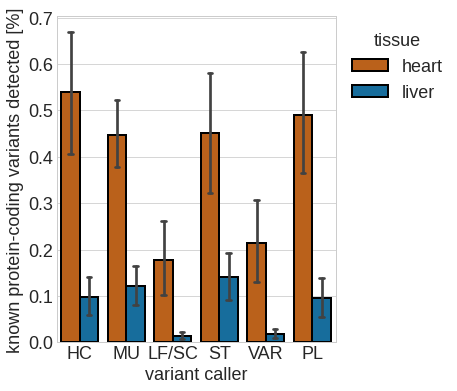

In [17]:
#How much percent of all protein coding variants (mgp database) was detected?
fig, ax = plt.subplots(1, figsize = (5,6))
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

sns.barplot(x="variant_caller", y=stat_dict_full["known_detected"] * 100, data=stat_dict_full,hue="tissue", ax = ax, palette = costum_palette, edgecolor = "black", capsize = 0.1, linewidth = 2)
ax.set_ylabel('known protein-coding variants detected [%]')
ax.set_xlabel('variant caller')

ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
fig.savefig(f'{outdir}/p_detected.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/p_detected.svg', bbox_inches = 'tight')

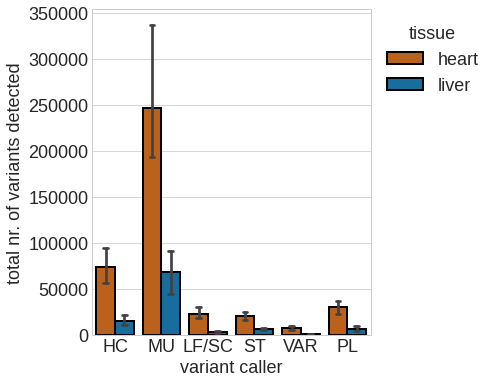

In [18]:
# How many variants were detected? (Only after PASS-filter, no further filtering)

fig, ax = plt.subplots(1, figsize = (5,6))
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

sns.barplot(x="variant_caller", y="len_all", data=stat_dict_full,hue="tissue", ax = ax, palette = costum_palette, edgecolor = "black", capsize = 0.1, linewidth = 2)
ax.set_ylabel('total nr. of variants detected')
ax.set_xlabel('variant caller')

ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
fig.savefig(f'{outdir}/no_variants.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/no_variants.svg', bbox_inches = 'tight')

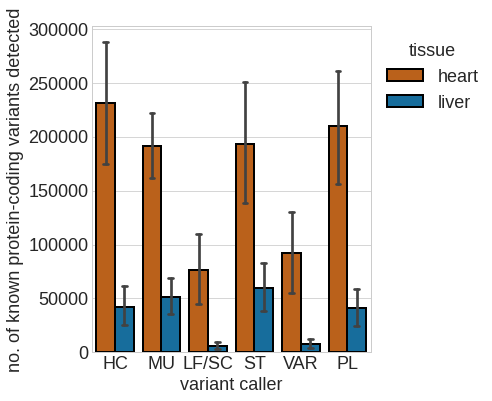

In [19]:
# How much percent of detected variants was previously known?

fig, ax = plt.subplots(1, figsize = (5,6))
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x="variant_caller", y=stat_dict_full["all"] * 100, data=stat_dict_full,hue="tissue", ax = ax, palette = costum_palette, edgecolor = "black", capsize = 0.1, linewidth = 2)
ax.set_ylabel('no. of known protein-coding variants detected')
ax.set_xlabel('variant caller')

ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
fig.savefig(f'{outdir}/known.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/known.svg', bbox_inches = 'tight')

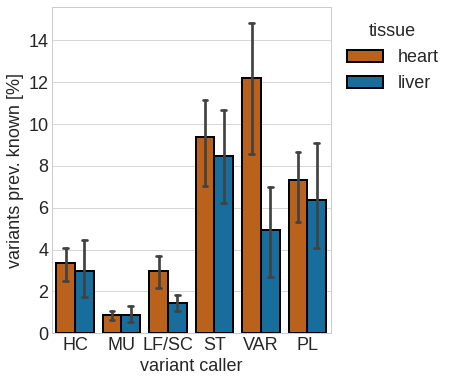

In [20]:
# How much percent of detected variants was previously known?

fig, ax = plt.subplots(1, figsize = (5,6))
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x="variant_caller", y=stat_dict_full["known_p_all"] * 100, data=stat_dict_full,hue="tissue", ax = ax, palette = costum_palette, edgecolor = "black", capsize = 0.1, linewidth = 2)
ax.set_ylabel('variants prev. known [%]')
ax.set_xlabel('variant caller')

ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
fig.savefig(f'{outdir}/p_known.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/p_known.svg', bbox_inches = 'tight')

In [21]:
# get overlap of different variant callers (two-way and three-way) and store in arrays
# store as absolute numbers and percentages (p-arrays)
three_array = list()
two_array = list()
three_p_array = list()
two_p_array = list()
name_array = list()
sample_array = list()
tissue_array = list()
variant_array = list ()

for variant in ['all', 'known', 'unknown']:
    if variant == 'all':
        venn_dict_use = venn_dict_all
    elif variant == 'known':
        venn_dict_use = venn_dict_known
    else:
        venn_dict_use = venn_dict_unknown
    for tissue in ['heart', 'liver']:
        # only every second enty in full dataframe belongs to one tissue
        if tissue == 'heart':
            combo_list = [0,2,4,6,8,10]
        else:
            combo_list = [1,3,5,7,9,11]
        # for each sample and for each combination of variant callers, 
        # calculate two-way and three-way overlap of variant callers
        for sample in samples:
            overlap_df = pd.DataFrame()

            for subset in itertools.combinations(combo_list, 3):
                a = subset[0]
                b = subset[1]
                c = subset[2]
                # union of all three variant callers
                total_vars = venn_dict_use[sample][0][:,a].sum() + venn_dict_use[sample][0][:,b].sum()+ venn_dict_use[sample][0][:,c].sum()
                # variants called by all three variant callers
                three_way = (
                (venn_dict_use[sample][0][:,a] &  
                venn_dict_use[sample][0][:,b] & 
                venn_dict_use[sample][0][:,c]
                ).sum())

                # variants called by two out of three variant callers
                two_way = (np.logical_or.reduce((
                    (venn_dict_use[sample][0][:,a] & venn_dict_use[sample][0][:,b]) ,
                    (venn_dict_use[sample][0][:,a] & venn_dict_use[sample][0][:,c]) , 
                    (venn_dict_use[sample][0][:,c] & venn_dict_use[sample][0][:,c])
                    )).sum())
                name = str(caller_order[a]+'-'+caller_order[b]+ '-'+caller_order[c])

                three_array.append(three_way)
                two_array.append(two_way)
                # percentage of all variants that overlap
                three_p_array.append(100*three_way/total_vars)
                two_p_array.append(100*two_way/total_vars)
                name_array.append(name)
                sample_array.append(sample)
                tissue_array.append(tissue)
                variant_array.append(variant)

overlap_df['three'] = three_array
overlap_df['two'] = two_array
overlap_df['three_p'] = three_p_array
overlap_df['two_p'] = two_p_array
overlap_df['caller'] = name_array
overlap_df['sample'] = sample_array
overlap_df['tissue'] = tissue_array
overlap_df['variant'] = variant_array

In [22]:
#save data as csv
overlap_df.to_csv(f'{outdir}/overlap_df.txt', index = False)

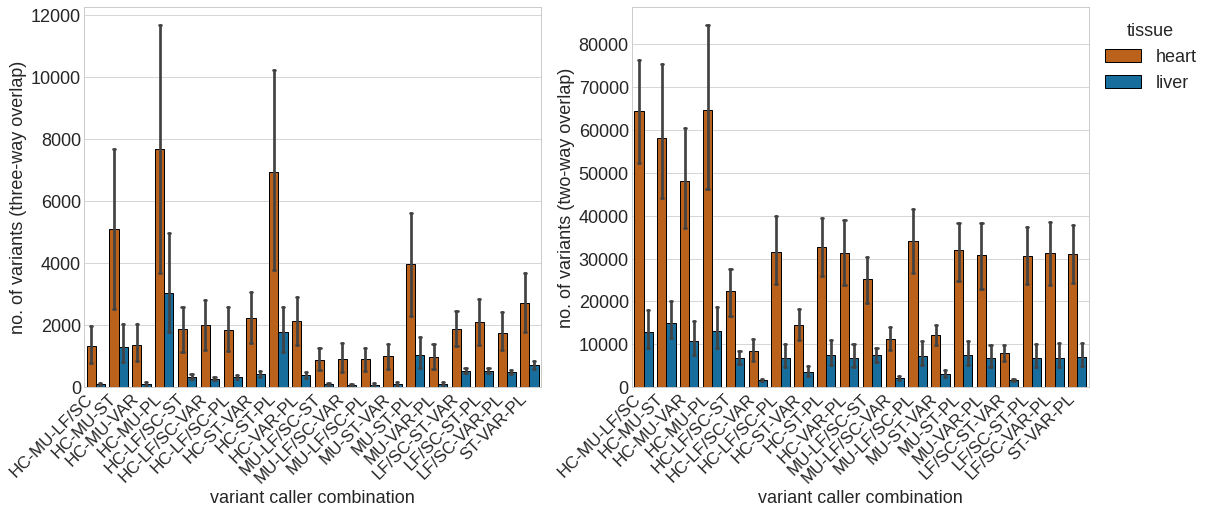

In [23]:
# number of variants that would be kept with three way (left) ot two-way (right) overlap

fig, ax = plt.subplots(1,2, figsize = (18,7), sharex=True)
plot = sns.barplot(x="caller", y="three", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[0], palette = costum_palette, edgecolor = "black", capsize = 0.1)
plot2 = sns.barplot(x="caller", y="two", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[1], palette = costum_palette, edgecolor = "black", capsize = 0.1)
ax[0].set_ylabel('no. of variants (three-way overlap)')
ax[1].set_ylabel('no. of variants (two-way overlap)')
ax[0].set_xlabel('variant caller combination')
ax[1].set_xlabel('variant caller combination')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
plot.set_xticklabels(plot.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
                        
plt.show()
fig.savefig(f'{outdir}/overlap_all.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/overlap_all.svg', bbox_inches = 'tight')

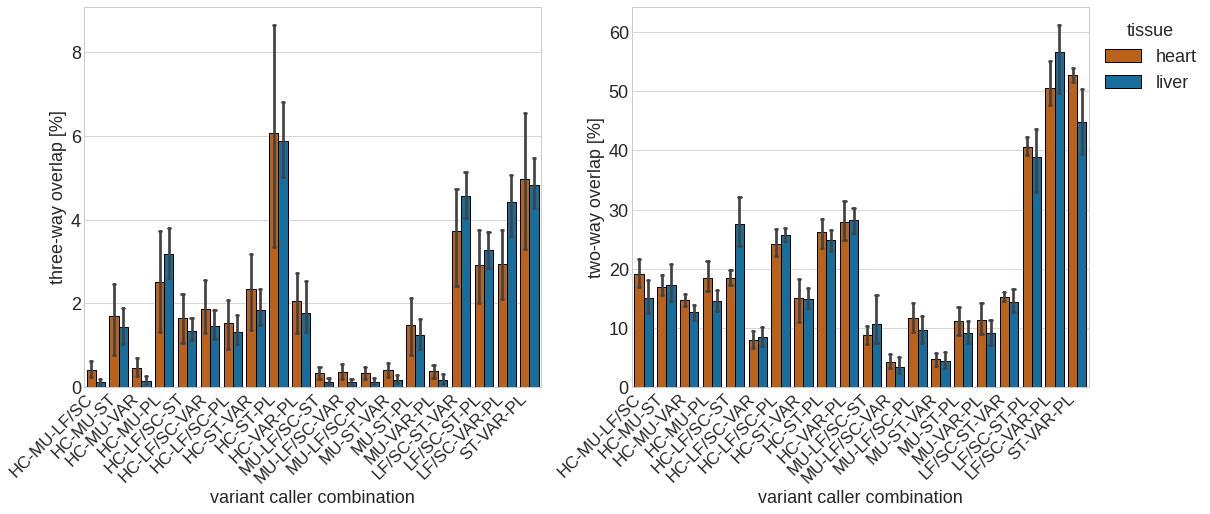

In [24]:
# percentage of variants called by three callers named that would be kept with three way (left) ot two-way (right) overlap


fig, ax = plt.subplots(1,2, figsize = (18,7), sharex=True)
plot = sns.barplot(x="caller", y="three_p", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[0], palette = costum_palette, edgecolor = "black", capsize = 0.1)
plot2 = sns.barplot(x="caller", y="two_p", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[1], palette = costum_palette, edgecolor = "black", capsize = 0.1)
ax[0].set_ylabel('three-way overlap [%]')
ax[1].set_ylabel('two-way overlap [%]')
ax[0].set_xlabel('variant caller combination')
ax[1].set_xlabel('variant caller combination')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
plot.set_xticklabels(plot.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
                        
plt.show()
fig.savefig(f'{outdir}/overlap_all_p.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/overlap_all_p.svg', bbox_inches = 'tight')

In [25]:
# plot settings
plt.rcParams.update({'font.size':20, 'text.usetex': False,
"svg.fonttype": 'none'})

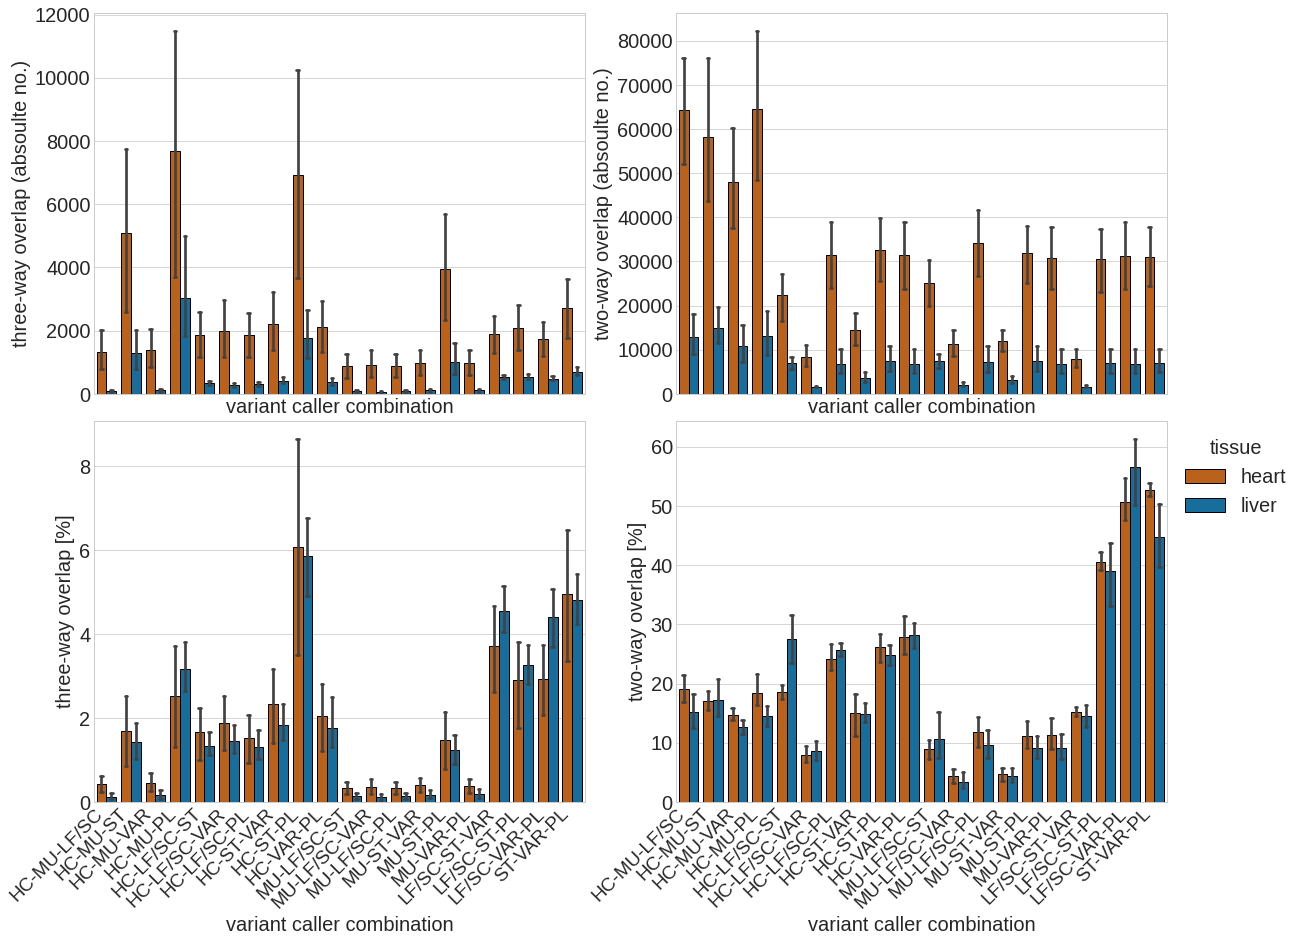

In [26]:
# percentage of variants called by three callers named that would be kept with three way (left) ot two-way (right) overlap


fig, ax = plt.subplots(2,2, figsize = (18,13), sharex = True)

plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x="caller", y="three", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[0,0], palette = costum_palette, edgecolor = "black", capsize = 0.1)
sns.barplot(x="caller", y="two", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[0,1], palette = costum_palette, edgecolor = "black", capsize = 0.1)

plot = sns.barplot(x="caller", y="three_p", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[1,0], palette = costum_palette, edgecolor = "black", capsize = 0.1)
plot2 = sns.barplot(x="caller", y="two_p", data=overlap_df[overlap_df['variant'] == 'all'],hue="tissue", ax = ax[1,1], palette = costum_palette, edgecolor = "black", capsize = 0.1)


ax[0,0].set_ylabel('three-way overlap (absoulte no.)')
ax[0,1].set_ylabel('two-way overlap (absoulte no.)')

ax[1,0].set_ylabel('three-way overlap [%]')
ax[1,1].set_ylabel('two-way overlap [%]')
ax[1,0].set_xlabel('variant caller combination')
ax[1,1].set_xlabel('variant caller combination')
ax[0,0].set_xlabel('variant caller combination')
ax[0,1].set_xlabel('variant caller combination')
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[0,0].get_legend().remove()
ax[1,1].legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
plot.set_xticklabels(plot.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 19)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 19)
                        
#plt.show()
fig.tight_layout(pad=0.2)
fig.savefig(f'{outdir}/overlap_all_p_and_abs.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/overlap_all_p_and_abs.svg', bbox_inches = 'tight')

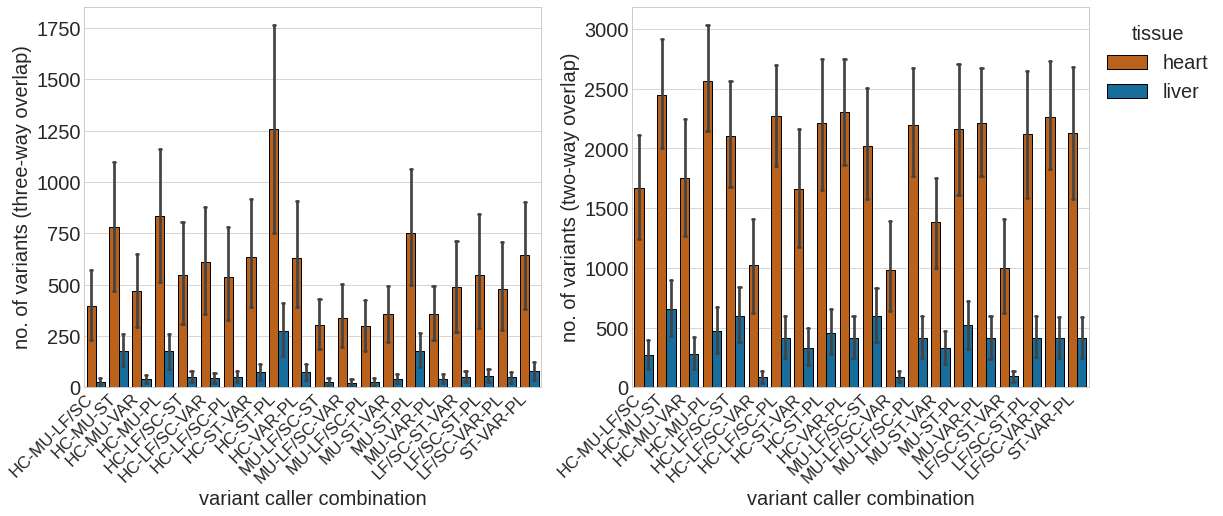

In [27]:
fig, ax = plt.subplots(1,2, figsize = (18,7), sharex=True)
plot = sns.barplot(x="caller", y="three", data=overlap_df[overlap_df['variant'] == 'known'],hue="tissue", ax = ax[0], palette = costum_palette, edgecolor = "black", capsize = 0.1)
plot2 = sns.barplot(x="caller", y="two", data=overlap_df[overlap_df['variant'] == 'known'],hue="tissue", ax = ax[1], palette = costum_palette, edgecolor = "black", capsize = 0.1)
ax[0].set_ylabel('no. of variants (three-way overlap)')
ax[1].set_ylabel('no. of variants (two-way overlap)')
ax[0].set_xlabel('variant caller combination')
ax[1].set_xlabel('variant caller combination')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
plot.set_xticklabels(plot.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
                        
plt.show()
fig.savefig(f'{outdir}/overlap_known.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/overlap_known.svg', bbox_inches = 'tight')

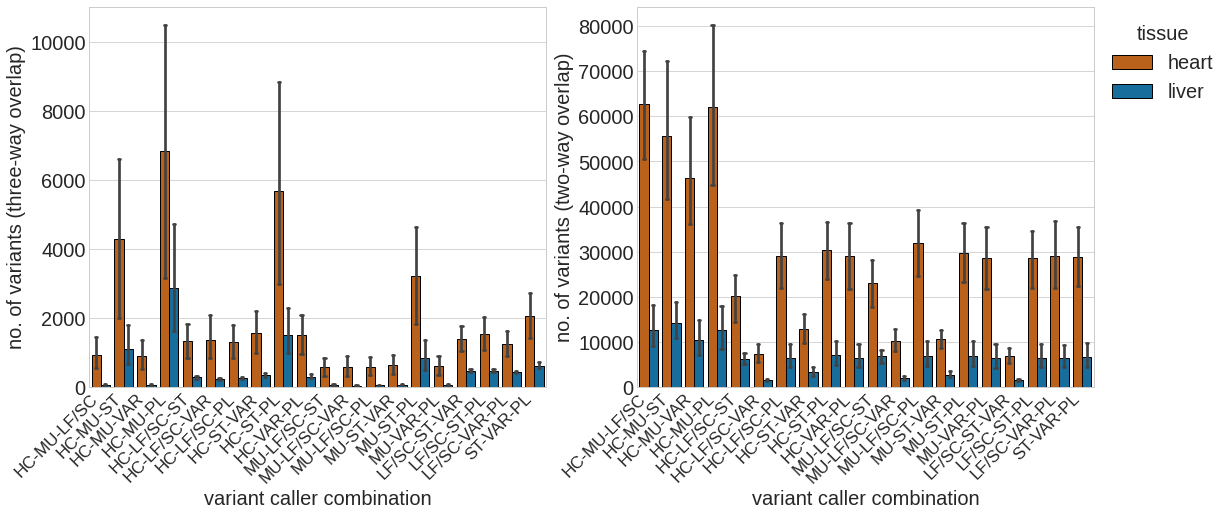

In [28]:
fig, ax = plt.subplots(1,2, figsize = (18,7), sharex=True)
plot = sns.barplot(x="caller", y="three", data=overlap_df[overlap_df['variant'] == 'unknown'],hue="tissue", ax = ax[0], palette = costum_palette, edgecolor = "black", capsize = 0.1)
plot2 = sns.barplot(x="caller", y="two", data=overlap_df[overlap_df['variant'] == 'unknown'],hue="tissue", ax = ax[1], palette = costum_palette, edgecolor = "black", capsize = 0.1)
ax[0].set_ylabel('no. of variants (three-way overlap)')
ax[1].set_ylabel('no. of variants (two-way overlap)')
ax[0].set_xlabel('variant caller combination')
ax[1].set_xlabel('variant caller combination')
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'tissue')
plot.set_xticklabels(plot.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right',
                          fontsize = 17)
                        
plt.show()
fig.savefig(f'{outdir}/overlap_unknown.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/overlap_unknown.svg', bbox_inches = 'tight')